## Introduction to fMRI data analysis with `nilearn`

<br /> <br />
<img style="float: right;" src="https://nilearn.github.io/_static/nilearn-logo.png" width=450>

**Karolina Finc**  
Centre for Modern Interdisciplinary Technologies  
Nicolaus Copernicus University in Toruń, Poland  
finc@umk.pl  


<br /> <br /> 
**Open and reproducible neuroimaging** 2020 | Day 2 

## Your current reproducible workflow
<br /> 
<center><img src="images/reproducible-pipeline.png" width=1200></center>

## What software to use?
<center><img src="images/software-fmri.png" width=1100></center>

All this stuff can be done in `nilearn`. <img style="float: right;" src="https://nilearn.github.io/_static/nilearn-logo.png" width=400>

## What is `nilearn`?

- `nilearn` is a Python library designed for statistical and machine learning analysis of fMRI data

- released in 2014 by Parietal Research Team at INRIA, currently over 100 contributors around the world

- it will soon (late 2020) be merged with `nistats` - library for Generalized Linear model (GLM) analysis

## Let's go for a walk with `nilearn`!

## Getting and looking at the data

You can easly load your data by providing paths to your preprocessed fMRI images (`*preproc_bold.nii.gz`)  or download data using nilearn's [`datasets`](https://nilearn.github.io/modules/reference.html#module-nilearn.datasets) module. 

In [63]:
# Import nilearn's datasets module
from nilearn import datasets

In [64]:
# Importing preprocessed fMRI data
fmri_data = datasets.fetch_development_fmri(n_subjects=1, reduce_confounds=False)

print(f'All keys associated with dataset: {fmri_data.keys()}')

All keys associated with dataset: dict_keys(['func', 'confounds', 'phenotypic', 'description'])


In [65]:
print(f'Paths to fMRI images: {fmri_data.func}')

Paths to fMRI images: ['/home/finc/nilearn_data/development_fmri/development_fmri/sub-pixar123_task-pixar_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz']


Let's load our fMRI data using `load_img` function from [`image`](http://nilearn.github.io/manipulating_images/input_output.html) module.

In [66]:
# Import nilearn's image module
from nilearn import image

In [67]:
# Load your fMRI data
fmri_images = image.load_img(fmri_data.func[0])

# Check your data shape
fmri_images.shape

(50, 59, 50, 168)

Your data are originally stored as 4D arrays (3D brain volumes acquired across time).

Let's look at the data using [`plotting`](https://nilearn.github.io/modules/reference.html#module-nilearn.plotting) module.  

In [68]:
# Import nilearn's plotting module
from nilearn import plotting

In [69]:
# Calculate mean fMRI image
mean_image = image.mean_img(fmri_images)

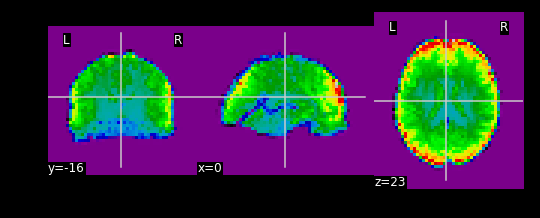

In [70]:
# Plot mean fMRI image
plotting.plot_epi(mean_image)

We now know how our data looks like, let's prepare them for analysis!

## Reducing dimensionality of the fMRI data

<center><img src="images/niimgs.jpg"></center>
<center><font size="2">Abraham et al. (2014)</font></center>

If you want to perform functional connectivity analysis or apply machine learning algorithm on fMRI data, you may want to reduce data dimensionality from 4D into 2D (3D images over time &#8594; features over time).  

You can reduce the dimensionality of the data by extracting mean signals from brain areas of interest, or signals from voxels within a predefined mask (e.g., gray matter, hippocampus).

<center><img src="images/masking.jpg" width=400></center>

To reduce dimensionality of our data we can use various [masker](https://nilearn.github.io/modules/generated/nilearn.input_data.NiftiMasker.html#nilearn.input_data.NiftiMasker) objects implemented in `nilearn`.

## Let's apply masking!

We apply `NiftiLabelsMasker` to extract mean signals from voxels that share a common label in a brain parcellation (see other types of [masking](https://nilearn.github.io/modules/reference.html#module-nilearn.input_data)).

In [71]:
# Import masking module
from nilearn.input_data import NiftiLabelsMasker

First, we have to load a **brain parcellation** that we want to use to extract our signals.

In [72]:
# Importing brain parcellation
parcellation = datasets.fetch_atlas_schaefer_2018(n_rois=100)
print(f'Path to Schefer parcellation: {parcellation.maps}')

Path to Schefer parcellation: /home/finc/nilearn_data/schaefer_2018/Schaefer2018_100Parcels_7Networks_order_FSLMNI152_1mm.nii.gz


:warning: **Matching parcellation for various templates**: To use parcellation that matches different templates, check out [templateflow](https://www.templateflow.org/usage).

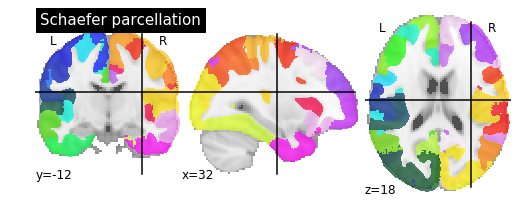

In [73]:
# Take a look at the parcellation
plotting.plot_roi(parcellation.maps, title="Schaefer parcellation")

In [74]:
# Create a masker object, and ask it to normalize, filter, and detrend your data
masker = NiftiLabelsMasker(parcellation.maps, 
                           detrend=True, standardize=True,
                           low_pass=0.1, high_pass=0.01, t_r=2)

Your preprocessed fMRI signals still contain a lot of motion and physiological noise. 
During extracting signals from brain parcellation you can also regress out potentially confounding variables.

In [75]:
# We import pandas to load table with condounds variables
import pandas as pd

# We load .tsv file
confounds_all = pd.read_csv(fmri_data.confounds[0], sep='\t')
print(confounds_all.columns)

Index(['csf', 'white_matter', 'global_signal', 'std_dvars', 'dvars',
       'framewise_displacement', 't_comp_cor_00', 't_comp_cor_01',
       't_comp_cor_02', 't_comp_cor_03', 't_comp_cor_04', 't_comp_cor_05',
       'a_comp_cor_00', 'a_comp_cor_01', 'a_comp_cor_02', 'a_comp_cor_03',
       'a_comp_cor_04', 'a_comp_cor_05', 'cosine00', 'cosine01', 'cosine02',
       'cosine03', 'trans_x', 'trans_y', 'trans_z', 'rot_x', 'rot_y', 'rot_z'],
      dtype='object')


Depending on your *denoising* strategy, 
you have to filter this dataframe to preserve confounds that you want to use.

In [76]:
# Here we will use 6 motion parameters, signal from CSF and WM to clean our data
confounds_filtered = confounds.filter(regex='rot|trans|csf|white_matter')

In [77]:
# Apply fit_transform method to extract timeseries and regress out confounding signals to 
# denoise your data
timeseries = masker.fit_transform(fmri_images, confounds=confounds_filtered.to_numpy())

# Check shape of the data
timeseries.shape

(168, 100)

:warning: **When using fMRPrep's confounds table**: Make sure you only use a selected columns from confounds table!

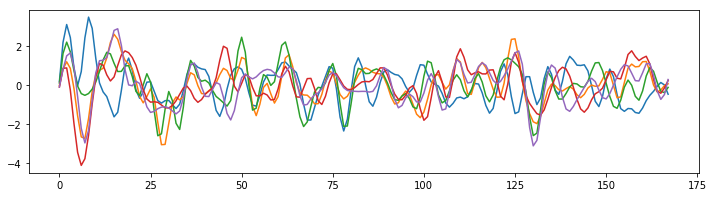

In [78]:
import matplotlib.pyplot as plt 

# Take a look at your signals
plt.figure(figsize=(12,3))
plt.plot(timeseries[:,:5]);

## Calculate connectivity between signals

In [79]:
# Import ConnectivityMeasure object from connectome module 
from nilearn.connectome import ConnectivityMeasure

In [80]:
# Create ConnectivityMeasure object to calculate association between signals
correlation_measure = ConnectivityMeasure(kind='correlation')

# Apply fit_transform method to callculate correlation
correlation_matrix = correlation_measure.fit_transform([timeseries])[0]

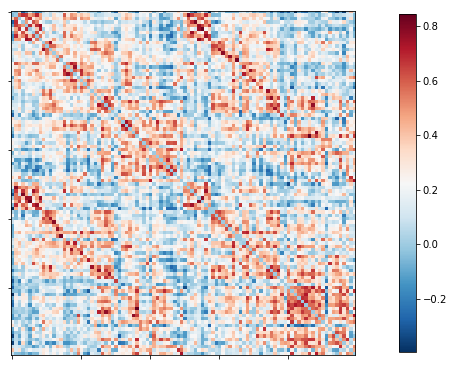

In [81]:
import numpy as np

# Fill all diaginal elements with 0
np.fill_diagonal(correlation_matrix, 0)

# Let's plot connectivity matrix
plotting.plot_matrix(correlation_matrix, figure=(6, 6))

In [82]:
# Find center coordinates for atlas labels
coordinates = plotting.find_parcellation_cut_coords(labels_img=parcellation.maps)

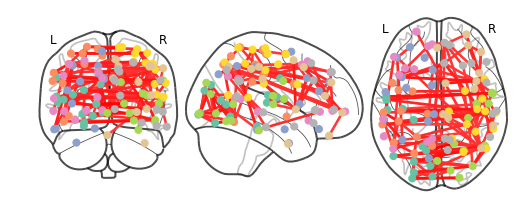

In [83]:
# Create a plot
plotting.plot_connectome(correlation_matrix, coordinates, edge_threshold=0.65)

In [84]:
# Create an interactive plot
plotting.view_connectome(correlation_matrix, coordinates, edge_threshold=0.65)

## Machine learning

`nilearn` is developed by the same team as `scikit-learn` - a Python library for machine learning analysis. You can directly use machine learning tools from `scikit-learn` on your data processed in `nilearn`. 

<img style="float: right;" src="images/scikit-learn-logo.png" width=500>

In [85]:
from sklearn.cluster import KMeans

In [86]:
# Create KMeans object
clustering = KMeans(n_clusters=5)

# Cluster timeseries
clustering.fit(timeseries)
clustering.labels_

array([1, 3, 3, 3, 1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       2, 2, 2, 2, 1, 4, 4, 4, 4, 4, 4, 2, 2, 2, 3, 3, 3, 1, 1, 2, 3, 0,
       0, 0, 1, 2, 1, 0, 0, 0, 1, 2, 2, 2, 3, 1, 1, 1, 3, 3, 3, 3, 1, 1,
       4, 4, 4, 4, 2, 2, 3, 3, 3, 3, 0, 0, 0, 4, 4, 1, 3, 3, 3, 3, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 0, 0, 0, 2, 2, 2, 2, 3, 0,
       0, 0, 0, 1, 1, 1, 3, 0, 0, 0, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2, 4, 4,
       4, 1, 3, 3, 3, 2, 1, 1, 0, 0, 1, 2, 2, 2, 0, 0, 4, 2, 2, 0, 0, 0,
       0, 3, 2, 2, 2, 3, 3, 3, 3, 3, 3, 1, 1, 3], dtype=int32)

In [87]:
from sklearn.decomposition import PCA 

In [88]:
# Create PCA object
decomposition = PCA(n_components=3)

# Cluster timeseries
decomposition.fit(timeseries)

PCA(copy=True, iterated_power='auto', n_components=3, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

## Summary

- `nilearn` allows us to easily load, manipulate, vizualize, and analyze fMRI data in Python


- more functionalities: [searchlight](https://nilearn.github.io/modules/generated/nilearn.decoding.SearchLight.html#nilearn.decoding.SearchLight), [independent component analysis](https://nilearn.github.io/modules/generated/nilearn.decomposition.CanICA.html#nilearn.decomposition.CanICA),  [surface plotting](https://nilearn.github.io/auto_examples/01_plotting/plot_3d_map_to_surface_projection.html#sphx-glr-auto-examples-01-plotting-plot-3d-map-to-surface-projection-py), [GLM](https://nistats.github.io/) (soon), and more! 

- check out the [documentation and examples](https://nilearn.github.io/)


- ... contribute to development of the tool!

Code from the presentation: https://github.com/kfinc/OaRN2020-nilearn-workshop  
Email: finc@umk.pl